In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

###Little function to plot acf and pacf on one figure

In [2]:
def acf_pacf(ts, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    

###Global temperatures series: the data are a combination of land-air yearly average temperature anomalies for the years 1900-1997.

In [3]:
df= pd.read_csv('data/globtemp.txt')
df=df[44:]
df.head()
df.shape

(98, 1)

In [4]:
df['dates'] = pd.date_range('1900','1998',freq='A')
df=df.set_index('dates')
df.head()

,temp_delta
dates,
1900-12-31,-0.13
1901-12-31,-0.22
1902-12-31,-0.37
1903-12-31,-0.44
1904-12-31,-0.49


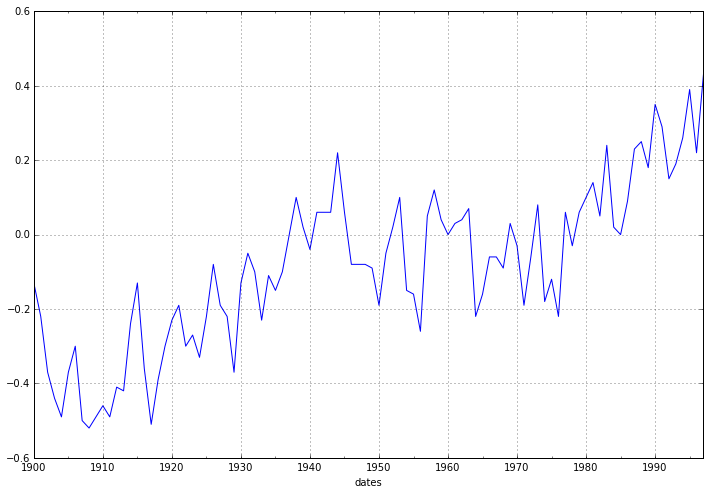

In [8]:
ts = pd.Series(df['temp_delta'])
ts.plot(figsize=(12,8))

Clearly increasing trend with possibley 2 inflection points

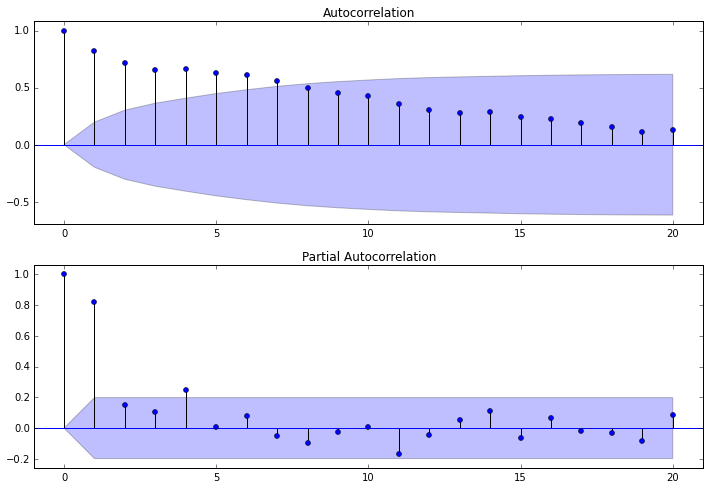

In [7]:
acf_pacf(ts, 20)

Nonstationary data, the ACF shows very slow decay, try first difference

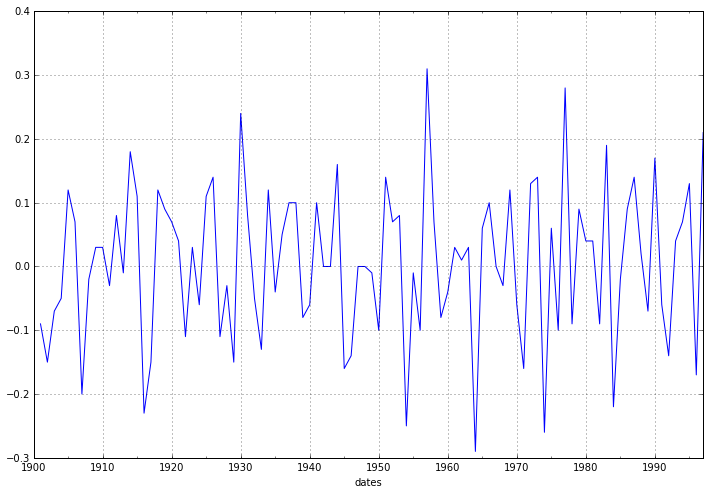

In [9]:
ts_diff=ts.diff(1)
ts_diff.plot(figsize=(12,8))

Clearly removed trend and the following ACF cuts off quickly

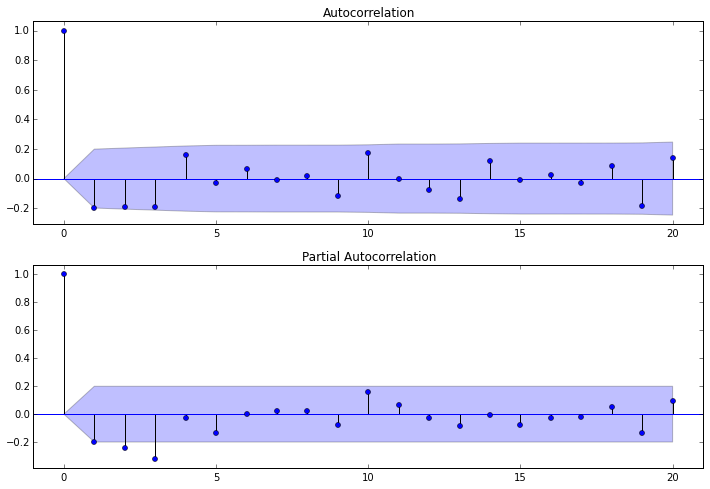

In [10]:
acf_pacf(ts_diff[1:],20)

Strong peak at lag 3 in the PACF indicating an AR(3) component, try an ARIMA(3,1,0) on the original undifferenced data...the I in the ARIMA refers to number of differences needed

In [11]:
model=sm.tsa.SARIMAX(ts, order=(3,1,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             temp_delta   No. Observations:                   98
Model:               SARIMAX(3, 1, 0)   Log Likelihood                  77.845
Date:                Fri, 25 Mar 2016   AIC                           -147.691
Time:                        14:34:17   BIC                           -137.351
Sample:                    12-31-1900   HQIC                          -143.508
                         - 12-31-1997                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.3351      0.098     -3.422      0.001        -0.527    -0.143
ar.L2         -0.3245      0.098     -3.307      0.001        -0.517    -0.132
ar.L3         -0.3388      0.099     -3.418      0.001        -0.533    -0.144
sigma2         0.0117      0.002      6.862      0.000         0.008     0.015
==============================================================================
"""

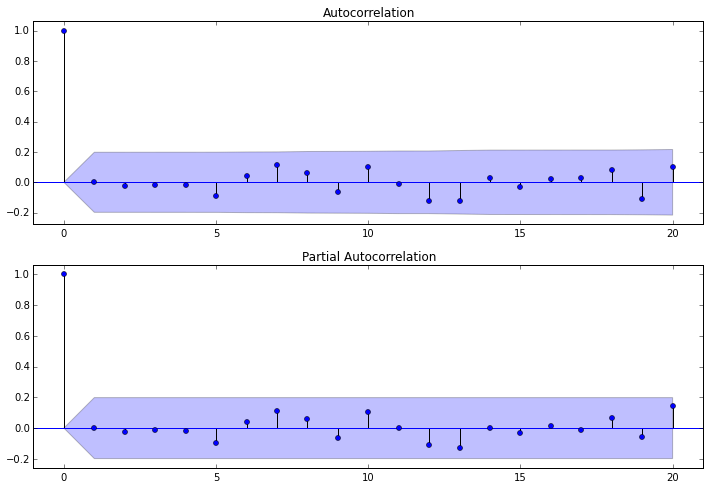

In [12]:
acf_pacf(pd.Series(model.resid().flatten(),index=ts.index), 20)

ACF and PACF show no strong lags

###Seasonal Quarterly Financial data from Johnson and Johnson 1960-1981

In [13]:
df= pd.read_csv('data/jj.txt')
df.head()

,earnings
0,0.71
1,0.63
2,0.85
3,0.44
4,0.61


In [14]:
dates = pd.date_range('1960','1981', freq='Q')
df['dates'] = dates
df['quarters'] = pd.DatetimeIndex(df['dates']).quarter
df.head()

,earnings,dates,quarters
0,0.71,1960-03-31,1
1,0.63,1960-06-30,2
2,0.85,1960-09-30,3
3,0.44,1960-12-31,4
4,0.61,1961-03-31,1


In [15]:
df=df.set_index('dates')
df.head()

,earnings,quarters
dates,,
1960-03-31,0.71,1
1960-06-30,0.63,2
1960-09-30,0.85,3
1960-12-31,0.44,4
1961-03-31,0.61,1


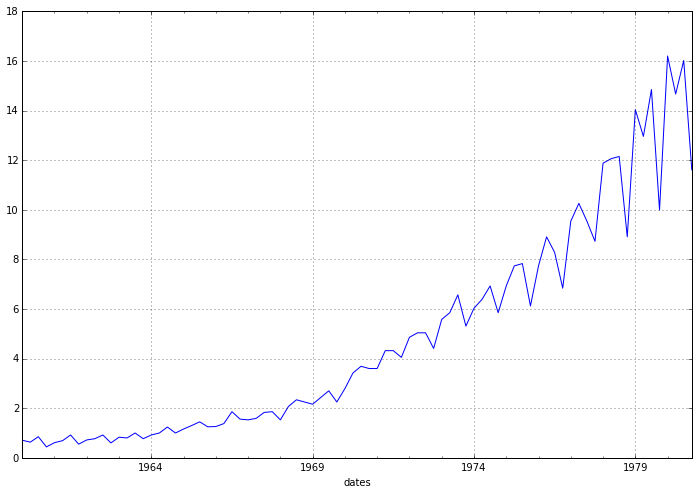

In [16]:
ts = pd.Series(df['earnings'])
ts.plot(figsize=(12,8))

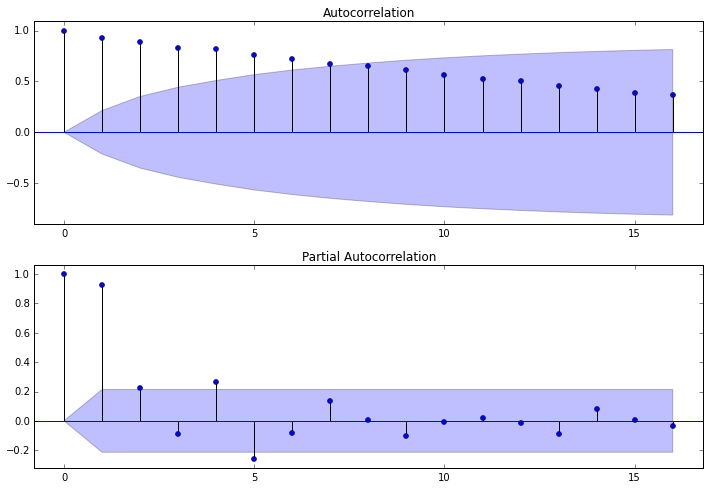

In [17]:
acf_pacf(ts,16)

Clearly nonstationary on both the conditions, hence the very slow decay in the ACF

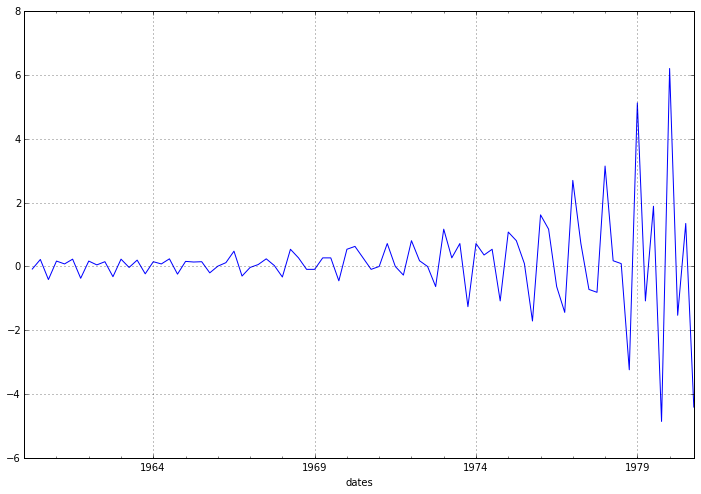

In [18]:
ts.diff(1).plot(figsize=(12,8))

After removing trend, the variance is obviously changing with time so we need to explore a variance stabilizing transform

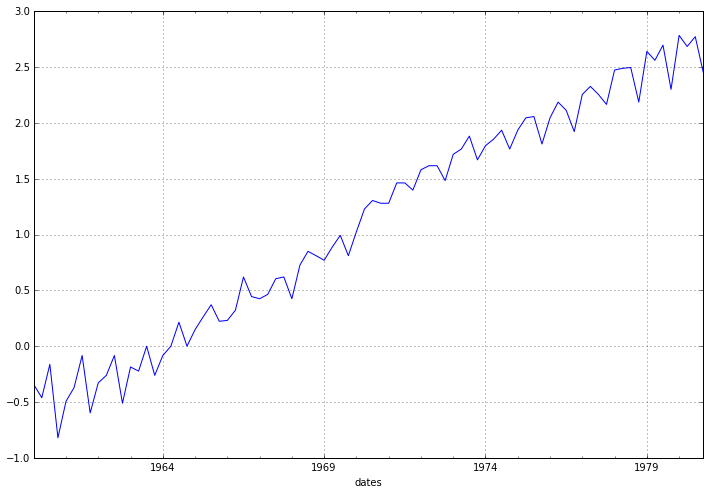

In [19]:
ts = pd.Series(np.log(df['earnings']))
ts.plot(figsize=(12,8))

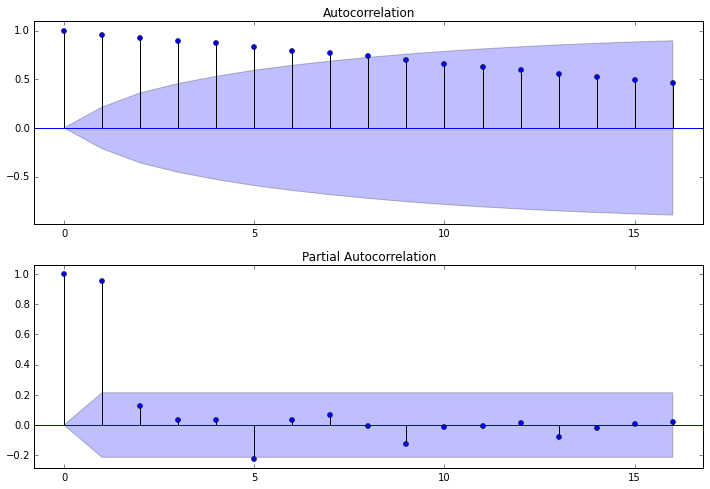

In [20]:
acf_pacf(ts,16)

Back to the slow decay in ACF due to the trend, so need to difference

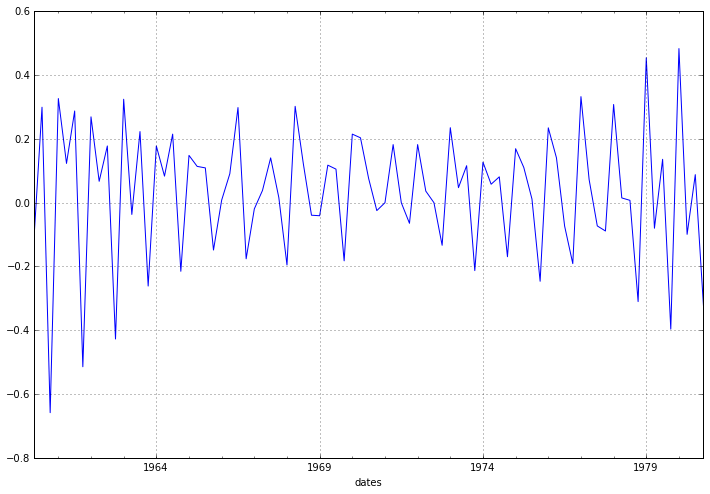

In [21]:
ts_diff=ts.diff(1)[1:]
ts_diff.plot(figsize=(12,8))

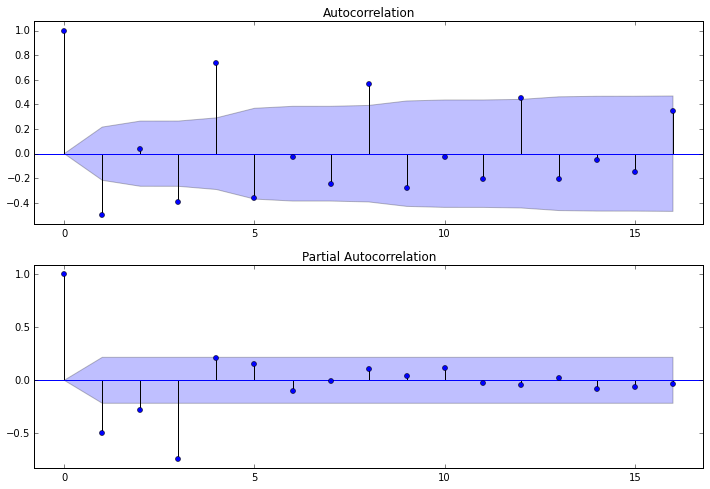

In [22]:
acf_pacf(ts_diff[1:],16)

Concentrating on the ACF, very slow decay in the seasonal lags indicating a seasonal difference could be needed

dates
1960-06-30         NaN
1960-09-30         NaN
1960-12-31         NaN
1961-03-31         NaN
1961-06-30    0.242778
Name: earnings, dtype: float64

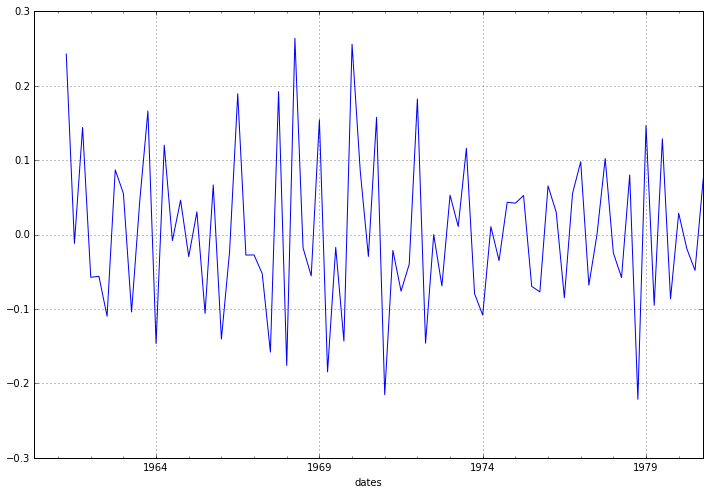

In [23]:
ts_sdiff = ts_diff.diff(4)
ts_sdiff.plot(figsize=(12,8))
ts_sdiff.head()

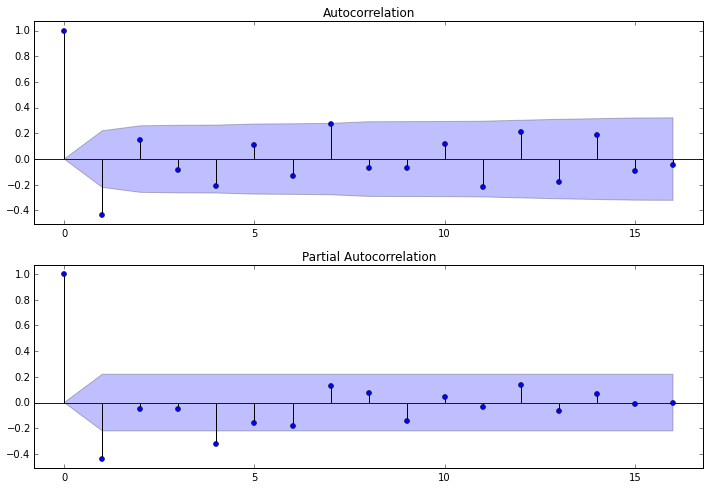

In [24]:
acf_pacf(ts_sdiff[4:], 16)

Data appears stationary. Significant peak at 1st seasonal lag in PACF indicating a possible Seasonal AR component...lets fit an ARIMA(0,1,0)x(1,1,0)x4 model

In [25]:
model=sm.tsa.SARIMAX(ts, order=(0,1,0), seasonal_order=(1,1,0,4)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          earnings   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  64.960
Date:                           Fri, 25 Mar 2016   AIC                           -125.920
Time:                                   14:43:55   BIC                           -121.058
Sample:                               03-31-1960   HQIC                          -123.965
                                    - 12-31-1980                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.S.L4       -0.2234      0.155     -1.442      0.149        -0.527     0.080
sigma2         0.0113      0.002      6.334      0.000         0.008     0.015
==============================================================================
"""

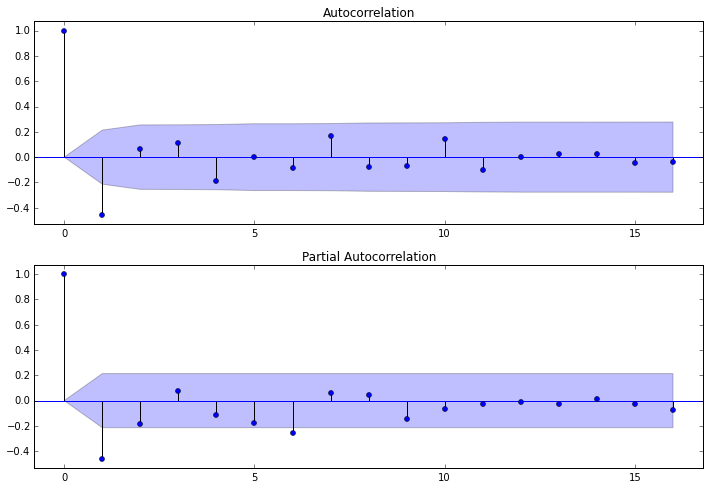

In [26]:
acf_pacf(pd.Series(model.resid().flatten(),index=ts.index), 16)

Here the ACF/PACF indicates either a potential nonseasonal AR(1) or nonseasonal MA(1) component...we will check both

In [27]:
model=sm.tsa.SARIMAX(ts, order=(1,1,0), seasonal_order=(1,1,0,4)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          earnings   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  76.016
Date:                           Fri, 25 Mar 2016   AIC                           -146.032
Time:                                   14:45:14   BIC                           -138.739
Sample:                               03-31-1960   HQIC                          -143.100
                                    - 12-31-1980                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.5153      0.095     -5.447      0.000        -0.701    -0.330
ar.S.L4       -0.3295      0.106     -3.104      0.002        -0.537    -0.121
sigma2         0.0085      0.001      6.257      0.000         0.006     0.011
==============================================================================
"""

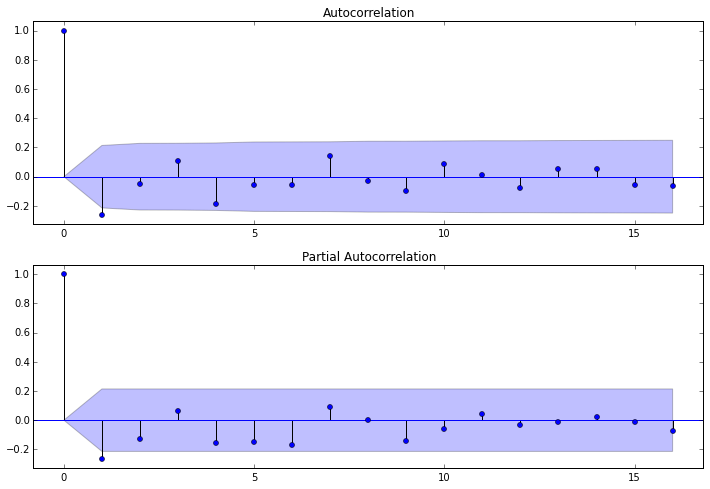

In [28]:
acf_pacf(pd.Series(model.resid().flatten(),index=ts.index), 16)

An AIC 0f -146.03 is the number to beat, now lets check the MA(1) model

In [29]:
model=sm.tsa.SARIMAX(ts, order=(0,1,1), seasonal_order=(1,1,0,4)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          earnings   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 4)   Log Likelihood                  78.457
Date:                           Fri, 25 Mar 2016   AIC                           -150.914
Time:                                   14:46:12   BIC                           -143.621
Sample:                               03-31-1960   HQIC                          -147.982
                                    - 12-31-1980                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ma.L1         -0.6796      0.096     -7.084      0.000        -0.868    -0.492
ar.S.L4       -0.3220      0.100     -3.234      0.001        -0.517    -0.127
sigma2         0.0079      0.001      6.198      0.000         0.005     0.010
==============================================================================
"""

Looking at minimizing AIC, is an improvement over the ARIMA(1,1,0)x(1,1,0)x4 model

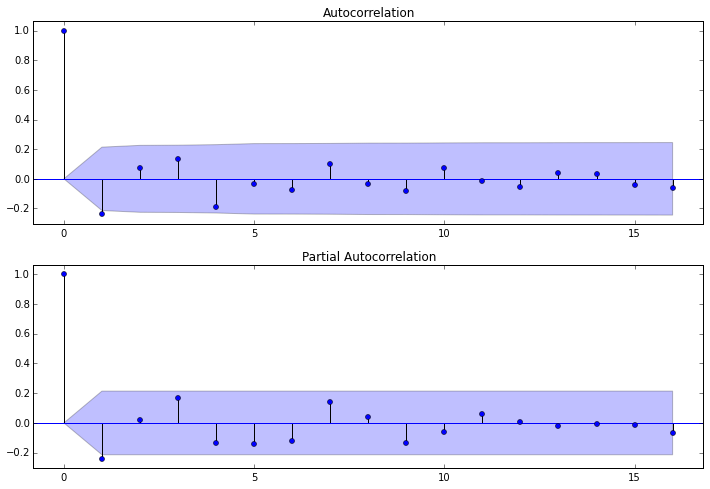

In [30]:
acf_pacf(pd.Series(model.resid().flatten(),index=ts.index), 16)

There is still a 'barely' significant lag 1, so lets try both AR(1) and MA(1) components and see if it can beet AIC of -150.9

In [31]:
model=sm.tsa.SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,0,4)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          earnings   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 4)   Log Likelihood                  78.459
Date:                           Fri, 25 Mar 2016   AIC                           -148.918
Time:                                   14:46:52   BIC                           -139.194
Sample:                               03-31-1960   HQIC                          -145.009
                                    - 12-31-1980                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.0141      0.529     -0.027      0.979        -1.051     1.023
ma.L1         -0.6700      0.406     -1.652      0.099        -1.465     0.125
ar.S.L4       -0.3264      0.233     -1.401      0.161        -0.783     0.130
sigma2         0.0079      0.001      6.225      0.000         0.005     0.010
==============================================================================
"""

Looking at minimizing AIC, not an improvement over the ARIMA(0,1,1)x(1,1,0)x4 model so that would be our final model.

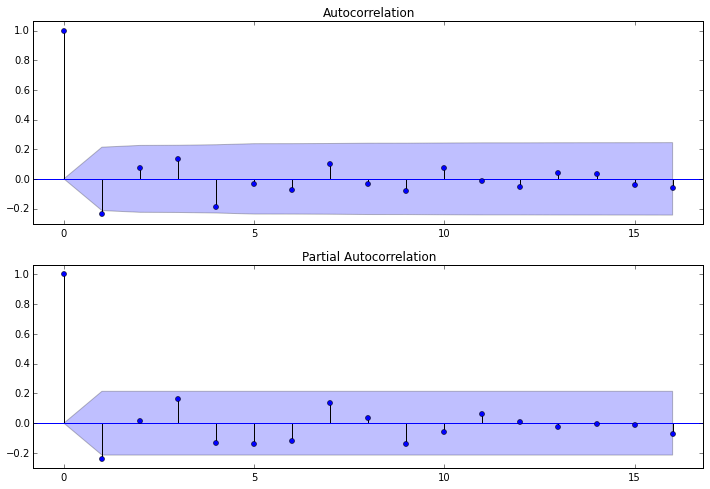

In [32]:
acf_pacf(pd.Series(model.resid().flatten(),index=ts.index), 16)